This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License, version 2, as published by the Free Software Foundation.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

Author: Alexander Young

### This notebook uses GPlates reconstructed geometries and sea floor age maps to model the time-dependent hypsometric slope following Algeo & Wilkinson, (1991). It then combines paleobathymetry calculated using 1_SeafloorBathymetry_from_AgeGrids_and_TrenchVolume.ipynb with the hypsometric slope and ETOPO (Amante & Eakins, 2009) continental elevations to produce a time-dependent hypsometry curve

##### Input:
reconstructed continent ocean boundaries e.g. reconstructed_0.00Ma.xy

sea floor age maps

ETOPO grid e.g. topo_resample.nc

ETOPO hypsometry e.g. etopo1_hyp_curve.dat

time-dependent continental etopo elevations exported from GPlates as netCDF raster e.g. raster_data_topo_ice_1d_0.00Ma.nc

##### Output:
time-dependent average hypsometric slope file e.g. 01072020_HypsoSlope_allTimes_0-580.csv

time-dependent bathymetric hypsometry model e.g. hypsoModel_BathyModelHypso_KRCC_0Ma.csv

time-dependent cumulative hypsometry model e.g. hypsoModel_HypsoModelFinal_0Ma_fOA_fS_KRCC.csv

##### Citations:
Algeo, T., and Wilkinson, B., 1991, Modern and ancient continental hypsometries: Journal of the Geological Society, v. 148, no. 4, p. 643-653.

Amante, C., and Eakins, B. W., 2009, ETOPO1 arc-minute global relief model: procedures, data sources and analysis.

Eakins, B., and Sharman, G., 2012, Hypsographic curve of Earth’s surface from ETOPO1: NOAA National Geophysical Data Center, Boulder, CO.

In [22]:
from __future__ import print_function
import math
import os
import os.path
import sys
sys.path.insert(1, '/Users/ajy321/pygplates_rev18_python27_MacOS64')
import pygplates
# Add directory containing the 'ptt' module (Plate Tectonic Tools) to the Python path.
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.interpolate as spi
import numpy as np
from matplotlib import cm
from functools import reduce
from sklearn.preprocessing import minmax_scale
import random
import scipy.stats as statistics
import scipy.ndimage
os.chdir('/Users/ajy321/PhD_work/SeaLevel/SeaLevel_MS/PythonNotebooks/PlateTectonicTools')
import subduction_convergence
import ridge_spreading_rate

date = '06072021'

root = '/Users/ajy321/PhD_work/SeaLevel/SeaLevel_MS/GPlatesFiles/'

# Input rotation and topology files.
rotation_filename = [root+'1000-410_rotations-NNR.rot', 
                     root+'Global_EB_250-0Ma_GK07_2017-NNR.rot', 
                     root+'Global_EB_410-250Ma_GK07_2017-NNR.rot', 
                     root+'NR_0Ma_1000Ma_for_gplates.rot']

rotation_model = pygplates.RotationModel(rotation_filename)

# Output file containing results at each reconstruction time.
output_filename = 'output.txt'

# Base filename and extension of raster to sample.
raster_filename_base ='/Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/AgeGrids/Mask/agegrid_final_masked'
raster_filename_ext = 'nc'

# Define the time range.
# The reconstruction time range (topologies resolved to these times).
# Also used to get paleo raster filenames based on 'raster_filename_base'.
min_time = 0
max_time = 20
time_step = 20

# Tessellate the subduction zones to 0.5 degrees.
tessellation_threshold_radians = math.radians(0.5)

# Define finctions for coastal hypsometry 
# Calculate passive margin costal gradient as in Algeo & Wilkinson, (1991)
def pmcoastal_gradient(row):
    return (-0.0062*row['pm_plate_age']+ 1.28)
def smcoastal_gradient(row):
    return (-0.0062*row['sm_plate_age']+ 1.28)

# Calculate slope as in Algeo & Wilkinson, (1991)
def pmslope(row):
    return row['pm_length_km']/row['pm_gradient']
def smslope(row):
    return row['sm_length_km']/row['sm_gradient']

# -- load Hypsometric curve for etopo1 produced by Eakins et al., 2012
# -- set output file names 
etopoHistFile="/Users/ajy321/PhD_work/SeaLevel/SeaLevel_MS/PythonNotebooks/DependentInputs/etopo1_hyp_curve.dat"
etopoHist = pd.read_csv(etopoHistFile, skiprows=1, names=['ELEVATION', 'Area_per'],
                        delim_whitespace=True, usecols=['ELEVATION', 'Area_per'])

# Set model name
model = 'gld428'

# set working directory and make if it does not exist
workDir="/Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/HypsometryModeling"
if not os.path.exists(workDir):
    os.makedirs(workDir)

In [8]:
# program to Sample grids
# The method used here for sampling of masked (NaN) rasters is faster than using the 'raster_query' module.

try:
    from netCDF4 import Dataset as netcdf
except ImportError:
    from scipy.io import netcdf_file as netcdf
    print('Warning: NetCDF4 grids not supported ("netCDF4" Python module not found). '
          'Falling back to NetCDF3, rasters may fail to load.', file=sys.stderr)

import scipy.interpolate as spi
import numpy as np

def sample_grid_using_scipy(x,y,grdfile):
    
    data=netcdf(grdfile,'r')
    try:
        lon = np.copy(data.variables['x'][:])
        lat = np.copy(data.variables['y'][:])
    except:
        lon = np.copy(data.variables['lon'][:])
        lat = np.copy(data.variables['lat'][:])
    
    Zg = data.variables['z'][:]
    
    test = fill_ndimage(Zg)
    
    lut=spi.RectBivariateSpline(lon,lat,test.T)
    result = []
    for xi,yi in zip(x,y):
        result.append(lut(xi, yi)[0][0])
            
    return result


from scipy import ndimage as nd

def fill_ndimage(data,invalid=None):
    """Replace the value of invalid 'data' cells (indicated by 'invalid')
    by the value of the nearest valid data cell
    Parameters
    ----------
    data: numpy array of any dimension
    invalid: a binary array of same shape as 'data'. True cells set where data
    value should be replaced.
    If None (default), use: invalid = np.isnan(data)
    Returns
    -------
    Return a filled array.
    Credits
    -------
    http://stackoverflow.com/a/9262129
    """
    if invalid is None: invalid = np.isnan(data)
    ind = nd.distance_transform_edt(invalid, return_distances=False, return_indices=True)
    return data[tuple(ind)]

In [10]:
# Reconstruction times.
reconstruction_times = np.arange(min_time, max_time, time_step)

# Create empty list for final hypsometric slope gradients and data
HypsoSlope = []
areaList = []
avePMslope = []
aveSMslope = []
PM_length = []
SM_length = []
avePM_age = []
pm_gradient = []


# Iterate over time steps
# Make a COB stencil and extract plate age at regularly spaced intervals
# then calculate hypsometric slope following Algeo & Wilkinson, (1991)
for reconstruction_time in reconstruction_times:
    
    topologyDir="/Users/ajy321/PhD_work/SeaLevel/SeaLevel_MS/GPlatesFiles/TopologiesExport"
    szFile=topologyDir+"/topology_subduction_boundaries_%d.00Ma.xy" %(reconstruction_time)

    # Determine paleo raster filename.
    raster_filename = '{0}_{1}.{2}'.format(raster_filename_base, reconstruction_time, raster_filename_ext)

    # Convert age grid NaNs (continental area) to 1 (here we are making a COB mask)
    cmd="grdmath %s ISNAN = tmp.grd" %(raster_filename)
    print (cmd)
    os.system(cmd)
    
    # Change oceanic area values to 0
    cmd="grdclip -V tmp.grd -Gtmp2.grd -Sb1/0"
    print (cmd)
    os.system(cmd)
    
    # Resample grid to 1d
    cmd="grdsample tmp2.grd -I1d -GageGridZeros_and_Ones.grd"
    print (cmd)
    os.system(cmd)
    
    # Contour age grid Nans and Zeros grid (this is the geometry we will use to extract plate age)
    cmd="grdcontour ageGridZeros_and_Ones.grd -L0/1 -C1 -V -DEarthByte_COB_%sMa_contour.txt" %(reconstruction_time)
    print (cmd)
    os.system(cmd)

    # Make SZ stencil grid
    cmd="grdmask %s -Rg -I1d -m -N1/0/0 -S300fk -GSZ_300kmStencilMask_%sMa.nc" %(szFile, reconstruction_time)
    print (cmd)
    os.system(cmd)

    # Contour SZ stencil grid
    cmd="grdcontour SZ_300kmStencilMask_%sMa.nc -L0/1 -C1 -V -DSZ_300kmStencilMask_%sMa_contour.txt" %(reconstruction_time, reconstruction_time)
    print (cmd)
    os.system(cmd)
    
    # Truncate COB polygons against subduction zone polygons
    cmd="gmt select -FSZ_300kmStencilMask_%sMa_contour.txt -If -fg EarthByte_COB_%sMa_contour.txt > %sMa_PassiveMargins.txt" %(reconstruction_time, reconstruction_time, reconstruction_time)
    print (cmd)
    os.system(cmd)
    
    # Truncate COB polygons against passive margin polygons
    cmd="gmt select -F%sMa_PassiveMargins.txt -If -fg EarthByte_COB_%sMa_contour.txt > %sMa_SubductionMargins.txt" %(reconstruction_time, reconstruction_time, reconstruction_time)
    print (cmd)
    os.system(cmd)
    
    # Calculate area of COB
    cmd="grdvolume -Sk ageGridZeros_and_Ones.grd -Rg -C0 | awk '{print $2}'"
    #print cmd
    Area=(float(os.popen(cmd).read()))
    
    # Load in subduction margin data
    SMdata = pd.read_csv('%sMa_SubductionMargins.txt' %(reconstruction_time), sep= '\t',names=['long', 'lat'], index_col=False)
    
    # drop NaNs
    smdf = SMdata.dropna()
    
    # sort columns (lat, long)
    smdf = smdf.reindex(sorted(smdf.columns), axis=1)

    # Calculate coastal gradient at subduction margin points following Algeo & Wilkinson, (1991)
    sm_lons = smdf['long'].values.tolist()
    sm_lats = smdf['lat'].values.tolist()
    sm_df = pd.DataFrame({'long':sm_lons,'lat':sm_lats})  
    sm_df['sm_plate_age'] = 0.
    sm_df['reconstruction_time'] = reconstruction_time
    sm_df['sm_length_km'] = math.radians(1.) * pygplates.Earth.mean_radius_in_kms
    sm_df['sm_gradient']=sm_df.apply(smcoastal_gradient, axis=1)    
    sm_df['sm_slope']=sm_df.apply(smslope, axis=1)    
    sm_df.to_csv('SubMargin_dataframe_%sMa.csv' %(reconstruction_time))

    # Load in passive margin data
    PMdata = pd.read_csv('%sMa_PassiveMargins.txt' %(reconstruction_time), sep= '\t',names=['long', 'lat'], index_col=False)
    
    # drop NaNs
    df = PMdata.dropna()
    
    # sort columns (lat, long)
    df = df.reindex(sorted(df.columns), axis=1)

    # convert df to numeric
    df = df.convert_objects(convert_numeric=True)
    df['lon2'] = df['long'].apply(lambda x: x+360 if x <= 0 else x)

    # Determine paleo raster filename.
    raster_filename = '{0}_{1}.{2}'.format(raster_filename_base, reconstruction_time, raster_filename_ext)
    
    # Sample raster/grid at subduction points and calculate costal gradient.
    lons = df['lon2'].values.tolist()
    lats = df['lat'].values.tolist()
    plate_age = sample_grid_using_scipy(lons, lats, raster_filename)
    length_km = math.radians(1.) * pygplates.Earth.mean_radius_in_kms
    pm_df = pd.DataFrame({'pm_plate_age':plate_age,'pm_length_km':length_km,'lons':lons,'lats':lats})
    pm_df['pm_plate_age'] = np.where(pm_df['pm_plate_age'] >= 120.0, 120., pm_df['pm_plate_age'])    
    pm_df['reconstruction_time'] = reconstruction_time
    pm_df['pm_gradient']=pm_df.apply(pmcoastal_gradient, axis=1)    
    pm_df['pm_slope']=pm_df.apply(pmslope, axis=1)    

#     pm_df.to_csv(workDir+'/PassiveMargin_dataframe_%sMa.csv' %(reconstruction_time))
    
    df_AllPoints = pd.concat([pm_df, sm_df], ignore_index=True, sort =False)
    HypsoSlope.append(1.75e8/((df_AllPoints['pm_slope'].sum() + df_AllPoints['sm_slope'].sum())*100.))
    areaList.append(Area)
    avePMslope.append(df_AllPoints['pm_slope'].mean())
    aveSMslope.append(df_AllPoints['sm_slope'].mean())
    PM_length.append(df_AllPoints['pm_length_km'].sum())
    SM_length.append(df_AllPoints['sm_length_km'].sum())
    avePM_age.append(df_AllPoints['pm_plate_age'].mean())
    pm_gradient.append(df_AllPoints['pm_gradient'].mean())

HypsoSlope_allTimes = pd.DataFrame({'HypsoSlope':HypsoSlope, 'Time':reconstruction_times,
                                   'Area':areaList,
                                   'avePMslope':avePMslope,'PM_length':PM_length, 'avePM_age':avePM_age, 'pm_gradient':pm_gradient,
                                   'SM_length':SM_length, 'aveSMslope':aveSMslope})

# Save results to csv
HypsoSlope_allTimes.to_csv(workDir+'/%s_HypsoSlope_allTimes_%s-%s.csv' %(date, min_time, max_time))

grdmath /Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/AgeGrids/Mask/agegrid_final_masked_0.nc ISNAN = tmp.grd
grdclip -V tmp.grd -Gtmp2.grd -Sb1/0
grdsample tmp2.grd -I1d -GageGridZeros_and_Ones.grd
grdcontour ageGridZeros_and_Ones.grd -L0/1 -C1 -V -DEarthByte_COB_0Ma_contour.txt
grdmask /Users/ajy321/PhD_work/SeaLevel/SeaLevel_MS/GPlatesFiles/TopologiesExport/topology_subduction_boundaries_0.00Ma.xy -Rg -I1d -m -N1/0/0 -S300fk -GSZ_300kmStencilMask_0Ma.nc
grdcontour SZ_300kmStencilMask_0Ma.nc -L0/1 -C1 -V -DSZ_300kmStencilMask_0Ma_contour.txt
gmt select -FSZ_300kmStencilMask_0Ma_contour.txt -If -fg EarthByte_COB_0Ma_contour.txt > 0Ma_PassiveMargins.txt
gmt select -F0Ma_PassiveMargins.txt -If -fg EarthByte_COB_0Ma_contour.txt > 0Ma_SubductionMargins.txt


/Users/ajy321/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:101: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/Users/ajy321/anaconda2/lib/python2.7/site-packages/scipy/io/netcdf.py:317: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


grdmath /Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/AgeGrids/Mask/agegrid_final_masked_20.nc ISNAN = tmp.grd
grdclip -V tmp.grd -Gtmp2.grd -Sb1/0
grdsample tmp2.grd -I1d -GageGridZeros_and_Ones.grd
grdcontour ageGridZeros_and_Ones.grd -L0/1 -C1 -V -DEarthByte_COB_20Ma_contour.txt
grdmask /Users/ajy321/PhD_work/SeaLevel/SeaLevel_MS/GPlatesFiles/TopologiesExport/topology_subduction_boundaries_20.00Ma.xy -Rg -I1d -m -N1/0/0 -S300fk -GSZ_300kmStencilMask_20Ma.nc
grdcontour SZ_300kmStencilMask_20Ma.nc -L0/1 -C1 -V -DSZ_300kmStencilMask_20Ma_contour.txt
gmt select -FSZ_300kmStencilMask_20Ma_contour.txt -If -fg EarthByte_COB_20Ma_contour.txt > 20Ma_PassiveMargins.txt
gmt select -F20Ma_PassiveMargins.txt -If -fg EarthByte_COB_20Ma_contour.txt > 20Ma_SubductionMargins.txt
grdmath /Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/AgeGrids/Mask/agegrid_final_masked_40.nc ISNAN = tmp.grd
grdclip -V tmp.grd -Gtmp2.grd -Sb1/0
grdsample tmp2.grd -I1d -GageGridZeros_and_Ones.grd
grdcon

grdcontour SZ_300kmStencilMask_220Ma.nc -L0/1 -C1 -V -DSZ_300kmStencilMask_220Ma_contour.txt
gmt select -FSZ_300kmStencilMask_220Ma_contour.txt -If -fg EarthByte_COB_220Ma_contour.txt > 220Ma_PassiveMargins.txt
gmt select -F220Ma_PassiveMargins.txt -If -fg EarthByte_COB_220Ma_contour.txt > 220Ma_SubductionMargins.txt
grdmath /Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/AgeGrids/Mask/agegrid_final_masked_240.nc ISNAN = tmp.grd
grdclip -V tmp.grd -Gtmp2.grd -Sb1/0
grdsample tmp2.grd -I1d -GageGridZeros_and_Ones.grd
grdcontour ageGridZeros_and_Ones.grd -L0/1 -C1 -V -DEarthByte_COB_240Ma_contour.txt
grdmask /Users/ajy321/PhD_work/SeaLevel/SeaLevel_MS/GPlatesFiles/TopologiesExport/topology_subduction_boundaries_240.00Ma.xy -Rg -I1d -m -N1/0/0 -S300fk -GSZ_300kmStencilMask_240Ma.nc
grdcontour SZ_300kmStencilMask_240Ma.nc -L0/1 -C1 -V -DSZ_300kmStencilMask_240Ma_contour.txt
gmt select -FSZ_300kmStencilMask_240Ma_contour.txt -If -fg EarthByte_COB_240Ma_contour.txt > 240Ma_PassiveMarg

grdmath /Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/AgeGrids/Mask/agegrid_final_masked_440.nc ISNAN = tmp.grd
grdclip -V tmp.grd -Gtmp2.grd -Sb1/0
grdsample tmp2.grd -I1d -GageGridZeros_and_Ones.grd
grdcontour ageGridZeros_and_Ones.grd -L0/1 -C1 -V -DEarthByte_COB_440Ma_contour.txt
grdmask /Users/ajy321/PhD_work/SeaLevel/SeaLevel_MS/GPlatesFiles/TopologiesExport/topology_subduction_boundaries_440.00Ma.xy -Rg -I1d -m -N1/0/0 -S300fk -GSZ_300kmStencilMask_440Ma.nc
grdcontour SZ_300kmStencilMask_440Ma.nc -L0/1 -C1 -V -DSZ_300kmStencilMask_440Ma_contour.txt
gmt select -FSZ_300kmStencilMask_440Ma_contour.txt -If -fg EarthByte_COB_440Ma_contour.txt > 440Ma_PassiveMargins.txt
gmt select -F440Ma_PassiveMargins.txt -If -fg EarthByte_COB_440Ma_contour.txt > 440Ma_SubductionMargins.txt
grdmath /Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/AgeGrids/Mask/agegrid_final_masked_460.nc ISNAN = tmp.grd
grdclip -V tmp.grd -Gtmp2.grd -Sb1/0
grdsample tmp2.grd -I1d -GageGridZeros_and_On

In [11]:
# if already run, load csv data
HypsoSlope_allTimes = pd.read_csv(workDir+'/%s_HypsoSlope_allTimes_%s-%s.csv' %(date, min_time, max_time))

In [13]:
# Create hypsometric curve from modeled bathymetry (modeled bath created during MOR & SZ volume calcs) and 
# present day continental elvation values. 
# Define histogram function from  Eakins et al., 2012
def HistogramCalculation(row):
        return (a**2. * d0 * d1 * math.cos(math.radians(row['Lat']) * (1. - e**2.)) / (1. - e**2. * math.sin(math.radians(row['Lat'])**2.))**2.)
    
# Here we decide which age depth model to implement
# Toggle age_depth_model to call model for simple plate, complex plate or half space cooling model.
# 0 simple plate, 1 half space cooling, 2 complex
age_depth_model = 1.

# Set sea floor bathymetry directory
if age_depth_model == 1.:
    coolingModel = 'HSCk'
    bathyGridDir = "/Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/BathymetryModeling/C1_Volumes/sz_MaskedBathy_%s" %(coolingModel)
elif age_depth_model == 0.:
    coolingModel = 'Pk'
    bathyGridDir = "/Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/BathymetryModeling/C1_Volumes/sz_MaskedBathy_%s" %(coolingModel)
else:
    coolingModel = 'KRCC'
    bathyGridDir = "/Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/BathymetryModeling/C1_Volumes/sz_MaskedBathy_%s" %(coolingModel)

# set out directory and make if it doesnt exist.
outdir = workDir+'/Bathy'
if not os.path.exists(outdir):
    os.makedirs(outdir)
    
# Reconstruction times.
reconstruction_times = np.arange(min_time, max_time, time_step)

# -- create time file loop
for reconstruction_time in reconstruction_times:
#     if reconstruction_time > 5.:
#         sys.exit()
    
    # -- path for input
    bathyFile=bathyGridDir+"/%s_bathy_sz_300km_%sMa.nc" %(coolingModel, reconstruction_time)
    etopo='/Users/ajy321/PhD_work/SeaLevel/SeaLevel_MS/PythonNotebooks/DependentInputs/contETOPO_export/raster_data_topo_ice_1d_%s.00Ma.nc' %(reconstruction_time)

    # -- path for output
    bathyxyz=outdir+'/cumulative_bathy_%s_300km_%dMa.xyz' %(coolingModel, reconstruction_time)
    bathyMerge=outdir+'/bathyMerge_%s_%dMa.nc' %(coolingModel, reconstruction_time)
    tmpgrd=outdir+'/tmp_etopo_resample.nc' %(reconstruction_time)
    tmp2grd=outdir+'/tmp2.nc'
    
    # -- resample etopo
    cmd="grdsample %s -I1d -G%s" %(etopo, tmpgrd)
    print (cmd)
    os.system(cmd)

    # -- Fill continental elevations with etopo values
    cmd="grdmath %s %s AND -V = %s" %(tmpgrd, bathyFile, bathyMerge)
    print (cmd)
    os.system(cmd)

    cmd="grdmath %s 0 AND = NaNtoZero.grd" %(bathyMerge)
    print (cmd)
    os.system(cmd)
    
    # -- convert to xyz file
    cmd="grd2xyz NaNtoZero.grd > %s" %(bathyxyz)
    print (cmd)
    os.system(cmd)
    
    # -- Load in modeled bathy xyz file
    tmp = pd.read_csv(bathyxyz, delimiter = "\t", header=None, names=['Long', 'Lat', 'ELEVATION'])
    
    # -- unload modeled bathy
    tmp['ELEVATION'] = tmp['ELEVATION'] * 0.6918238993710691
    
    # -- Drop rows that have NaN values from bathy xyz dataframe
    tmp= tmp[np.isfinite(tmp['ELEVATION'])]
    
    # calculate At/A0 through time with ap = 0.002
    a = 6378.137
    e = 0.08181919
    d0 = math.radians(0.0166667)
    d1 = math.radians(0.0166667)

    tmp['dA']=tmp.apply(HistogramCalculation, axis=1)    

    tmp = tmp.groupby(['ELEVATION'])['dA'].agg('sum')
    tmp = tmp.reset_index()
    
    tmp = tmp.sort_values(by='ELEVATION', ascending=False)
    
    tmp['cumulative_sum'] = tmp.dA.cumsum()
    
    total = tmp['dA'].sum()
    
    tmp['Area_per'] = (tmp.cumulative_sum/total)
    del tmp['dA']
    del tmp['cumulative_sum']

    # -- export model to csv
    tmp.to_csv(outdir+'/%s_BathyModelHypso_%s_%dMa.csv' %(model, coolingModel, reconstruction_time), index=False)
    
#     # -- Plot results
#     # -- clear old plots
#     plt.clf()
#     plt.cla()
#     plt.close()
    
#     # -- set figure size
#     fig = plt.figure(figsize=(10,5))
#     ax = fig.add_subplot(1,1,1)
    
#     # -- plot profiles
#     ax.plot(tmp['Area_per'], tmp['ELEVATION'], color='Red', linewidth=1., label = '%s %s BathyModel hypsometry' %(model, coolingModel))
#     ax.plot(etopoHist['Area_per'], etopoHist['ELEVATION'], color='blue', linewidth=1., label = 'Eakins et al., 2012')

#     # -- extract profile names for legend
#     handles, labels = ax.get_legend_handles_labels()
    
#     # -- plot legend
#     ax.legend(labels=labels, facecolor="white", loc='best', prop={'size': 14})
    
#     # -- axis labels
#     plt.xlabel ('Cumulative area')
#     plt.ylabel ('Elevation [m]')
    
#     # -- axis limits
#     plt.xlim((0.0,1.01))
#     plt.ylim((-10000.,10000.))
    
#     # -- grid line
#     ax.axhline(-200., linestyle='--', color='lightgrey', zorder=0) # horizontal lines
#     ax.axhline(-2309., linestyle='--', color='lightgrey', zorder=0) # horizontal lines
    
#     # -- plot title
#     plt.title("BathyModel hypsometry %sMa" %(reconstruction_time))
    
#     # -- save figure
#     plt.savefig(outdir+'/%s_BathyModelHypso_%s_%sMa.png' %(model, coolingModel, reconstruction_time), format='png', dpi=400 , bbox_inches = 'tight')

grdsample /Users/ajy321/PhD_work/SeaLevel/SeaLevel_MS/PythonNotebooks/DependentInputs/contETOPO_export/raster_data_topo_ice_1d_0.00Ma.nc -I1d -G/Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/HypsometryModeling/Bathy/tmp_etopo_resample.nc
grdmath /Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/HypsometryModeling/Bathy/tmp_etopo_resample.nc /Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/BathymetryModeling/C1_Volumes/sz_MaskedBathy_HSCk/HSCk_bathy_sz_300km_0Ma.nc AND -V = /Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/HypsometryModeling/Bathy/bathyMerge_HSCk_0Ma.nc
grdmath /Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/HypsometryModeling/Bathy/bathyMerge_HSCk_0Ma.nc 0 AND = NaNtoZero.grd
grd2xyz NaNtoZero.grd > /Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/HypsometryModeling/Bathy/cumulative_bathy_HSCk_300km_0Ma.xyz
grdsample /Users/ajy321/PhD_work/SeaLevel/SeaLevel_MS/PythonNotebooks/DependentInputs/contETOPO_export/raster_data_topo_ice_1d_

grdsample /Users/ajy321/PhD_work/SeaLevel/SeaLevel_MS/PythonNotebooks/DependentInputs/contETOPO_export/raster_data_topo_ice_1d_200.00Ma.nc -I1d -G/Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/HypsometryModeling/Bathy/tmp_etopo_resample.nc
grdmath /Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/HypsometryModeling/Bathy/tmp_etopo_resample.nc /Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/BathymetryModeling/C1_Volumes/sz_MaskedBathy_HSCk/HSCk_bathy_sz_300km_200Ma.nc AND -V = /Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/HypsometryModeling/Bathy/bathyMerge_HSCk_200Ma.nc
grdmath /Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/HypsometryModeling/Bathy/bathyMerge_HSCk_200Ma.nc 0 AND = NaNtoZero.grd
grd2xyz NaNtoZero.grd > /Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/HypsometryModeling/Bathy/cumulative_bathy_HSCk_300km_200Ma.xyz
grdsample /Users/ajy321/PhD_work/SeaLevel/SeaLevel_MS/PythonNotebooks/DependentInputs/contETOPO_export/raster_data_to

grdmath /Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/HypsometryModeling/Bathy/tmp_etopo_resample.nc /Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/BathymetryModeling/C1_Volumes/sz_MaskedBathy_HSCk/HSCk_bathy_sz_300km_380Ma.nc AND -V = /Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/HypsometryModeling/Bathy/bathyMerge_HSCk_380Ma.nc
grdmath /Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/HypsometryModeling/Bathy/bathyMerge_HSCk_380Ma.nc 0 AND = NaNtoZero.grd
grd2xyz NaNtoZero.grd > /Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/HypsometryModeling/Bathy/cumulative_bathy_HSCk_300km_380Ma.xyz
grdsample /Users/ajy321/PhD_work/SeaLevel/SeaLevel_MS/PythonNotebooks/DependentInputs/contETOPO_export/raster_data_topo_ice_1d_400.00Ma.nc -I1d -G/Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/HypsometryModeling/Bathy/tmp_etopo_resample.nc
grdmath /Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/HypsometryModeling/Bathy/tmp_etopo_resample.nc /Users/

Age is:  0.0
Area at 0m in etopo is:  0.29
Hypso Slope is:  2.81
Area from bathy is:  0.40478
Area at ridge depth in ETOPO is:  0.41474
Scaled Acc: 0.41558
Ash is:  0.35
modeled SL is:  0.3
Af is:  0.25
_topContinental is:  196.6
_baseContinental is:  97.0


/Users/ajy321/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:59: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ajy321/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:72: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ajy321/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ajy321/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:172: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/ajy321/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy o

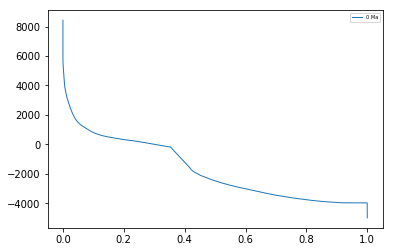

In [23]:
# Now combine all the components together
# Toggle age_depth_model to call model for half space cooling or simple plate.
# 0 Pk, 1 HSCk, 2 KRCC
age_depth_model = 0.

# Set sea floor bathymetry directory
if age_depth_model == 1.:
    coolingModel = 'HSCk'
    dmax = -1656. * 0.6918238993710691 # air-loaded ridge depth
elif age_depth_model == 0. :
    coolingModel = 'Pk'
    dmax = -2216. * 0.6918238993710691 # air-loaded ridge depth
else:
    coolingModel = 'KRCC'
    dmax = -2500. * 0.6918238993710691 # air-loaded ridge depth
    
    
# Reconstruction times.
reconstruction_times = np.arange(min_time, max_time, time_step)
AccList = []

# Toggle dynamicOceanArea to model if ocean basin area remains constant through time.
# 1 dynamic, 0 fixed
dynamicOceanArea = 0.

# Toggle dynamicSlope to model if slope is dependent on coastal gradient.
# 1 dynamic, 0 fixed
dynamicSlope = 0.

# -- create time file loop
for reconstruction_time in reconstruction_times:
#     if reconstruction_time > 10.:
#         sys.exit()
        
    print ("Age is: ",round(reconstruction_time, 2))
    
    # -- load Hypsometric curve for etopo1 produced by Eakins et al., 2012
    # -- set output file names 
    etopoHistFile="/Users/ajy321/PhD_work/SeaLevel/SeaLevel_MS/PythonNotebooks/DependentInputs/etopo1_hyp_curve.dat"
    etopoHist = pd.read_csv(etopoHistFile, skiprows=1, names=['ELEVATION', 'Area_per'],
                            delim_whitespace=True, usecols=['ELEVATION', 'Area_per'])
    
    etopoHist.loc[etopoHist.ELEVATION <= 0.0, 'ELEVATION_AL'] = etopoHist.ELEVATION * 0.6918238993710691 # air-loaded
    etopoHist.loc[etopoHist.ELEVATION > 0.0, 'ELEVATION_AL'] = etopoHist.ELEVATION

    # Load in modeled bathymetry hypsometric curve
    bathyHistFile='/Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/HypsometryModeling/Bathy/%s_BathyModelHypso_%s_%sMa.csv' %(model, coolingModel, reconstruction_time)
    bathyHist = pd.read_csv(bathyHistFile)
    
    # read through etopo and extract cumPer where etopo1 equals 0m, 200m (to fit costal hypsometry from Algeo & Wilkinson, 1991)
    # read through modeled bathymetry hypsometric curve and extract cumPer where elevation
    # is equal to -2216m (depth to ridge [zr] from Richards et al, 2018)
    
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]
    
    array = etopoHist.as_matrix(columns=etopoHist.columns[:1])
    a_ = 0.
    aa_ = np.asscalar(find_nearest(array, a_))
    index_loc_0m = etopoHist.loc[etopoHist['ELEVATION'] == aa_].index.tolist()
    cum_area_0m = float(etopoHist['Area_per'].iloc[index_loc_0m])
    print ("Area at 0m in etopo is: ",round(cum_area_0m, 2))
    
    # set coastal gradient for time in reconstruction_time
    x = (HypsoSlope_allTimes.loc[HypsoSlope_allTimes['Time'] == reconstruction_time, 'HypsoSlope'].item())
#     x = (HypsoSlope_allTimes.loc[HypsoSlope_allTimes['Time'] == 0., 'HypsoSlope'].item()) # toggle this to fix the slope
    print ("Hypso Slope is: ",round(x, 2))
    
    # -- split oceanic hypsometry profile at Zr
    array = bathyHist.as_matrix(columns=bathyHist.columns[:1])
    index_loc_Acc = abs(bathyHist['ELEVATION'] - dmax).idxmin()
    oceanicHypso = bathyHist.iloc[index_loc_Acc:]
    Acc = float(bathyHist['Area_per'].iloc[index_loc_Acc])
    print ("Area from bathy is: ",round(Acc, 5))

    # -- find area % of etopo hypsometry at Zr
    index_loc_Acc_etopo = abs(etopoHist['ELEVATION_AL'] - dmax).idxmin()
    observed_Acc = float(etopoHist['Area_per'].iloc[index_loc_Acc_etopo])
    print ("Area at ridge depth in ETOPO is: ",round(observed_Acc, 5))
    
    # Scale modeled oceanic hypsometry by an increase of ~3% to fit with present day
    # this accounts for NaN values in the bathy grid
    areaList = oceanicHypso['Area_per'].values
    oceanicHypso.drop(['Area_per'], axis=1, inplace=True)
    ScaledAcc = (Acc + (Acc * 0.026681))
    print ("Scaled Acc:",round(ScaledAcc, 5))
     
    if dynamicOceanArea == 1.:
        OAname = 'dOA'
        areaListSCALED = minmax_scale(areaList, feature_range=(ScaledAcc, 1.))
    else:
        OAname = 'fOA'
        areaListSCALED = minmax_scale(areaList, feature_range=(observed_Acc, 1.))
    
    # Add scaled to dataframe
    oceanicHypso['Area_per'] = areaListSCALED
    Acc = oceanicHypso["Area_per"].iloc[0]
    
    # Create a list from cum_area_0m to Acc (ridge depth) that contains 100 values
    slope_stepList = np.arange(0., Acc, 0.01)
    slope_stepList = sorted(slope_stepList, reverse=True)
    
    # Create an empty list to add continental slope hypsometry values to
    slope_eList = []
    
    # The gradient of the continental slope ~32000 is ~170% larger than the gradient of the coastal slope ~2500
    # from etopo
    
    for i in range(len(slope_stepList)):
        if dynamicSlope == 1.:
            Sname = 'dS'
            slope_eList.append(((dmax+100.) + ((x * 130.) * i)))
        else:
            Sname = 'fS'
            slope_eList.append(((dmax+100.) + ((1.7 * 130.) * i)))
    
    slopeHypso = pd.DataFrame({'ELEVATION':slope_eList,'Area_per':slope_stepList})
    
    # increase resolution
    slope_resample_list=np.arange(float(slopeHypso['Area_per'].iloc[-1]), float(slopeHypso['Area_per'].iloc[0]), 1e-4)
    slope_resampledf = pd.DataFrame({'Area_per':slope_resample_list})
    slope_hidef = pd.merge(slope_resampledf, slopeHypso, on='Area_per', how='outer')
    slope_hidef = slope_hidef.sort_values(by='Area_per', ascending=True)
    slope_hidef = slope_hidef.interpolate(method='linear', axis=0, limit=None, limit_direction='both').ffill().bfill()
    
    # Combine coastal elevations and cumulative area percentages into a dataframe and
    # drop all rows where elveation < -250 m
    slope_hidef = slope_hidef[slope_hidef['ELEVATION'] <= (-250. * 0.6918238993710691)] # air-loaded
    
    # Model coastal gradient
    # Ash is the limit of continental crust, according to our model approximatly -250m
    Ash = slope_hidef["Area_per"].iloc[0]
    print ("Ash is: ",round(Ash, 2))

    # Create a list from cum_area_0m to cum_area_200m that contains 100 values
    coast_stepList = np.arange(0., (Ash), 0.01)
    coast_stepList = sorted(coast_stepList, reverse=True)
    
    # Create an empty list to add coastal hypsometry values to
    coast_eList = []
    
    # Using loop calculate elevation at each "area %" from 200 to -250m and append values to eList
    # 13x multiplier accounts for 200 to -250m representing ~13% of the total hypso curve. 
    # the (0.8*(i + 1.)**0.5) part of the equation adds a slight curvature to the deeper part of the profile.
    # The Algeo & Wilkinson, 1991 hypso slope calculation returns a gradient in m/%area for the 200 - 0m only. 
    for i in range(len(coast_stepList)):
        coast_eList.append((-250. * 0.6918238993710691) + (x * 13. * i))      # air-loaded                
    
    # Combine coastal elevations and cumulative area percentages into a dataframe
    coastalHypso = pd.DataFrame({'ELEVATION':coast_eList,'Area_per':coast_stepList})
    
    # increase resolution
    coast_resample_list=np.arange(float(coastalHypso['Area_per'].iloc[-1]), float(coastalHypso['Area_per'].iloc[0]), 1e-3)
    coast_resampledf = pd.DataFrame({'Area_per': coast_resample_list})
    coast_hidef = pd.merge(coast_resampledf, coastalHypso, on='Area_per', how='outer')
    coast_hidef = coast_hidef.sort_values(by='Area_per', ascending=True)
    coast_hidef = coast_hidef.interpolate(method='linear', axis=0, limit=None, limit_direction='both').ffill().bfill()
    
    # Check sea level area. 
    _SL = 0.
    index_loc_SL = abs(coastalHypso['ELEVATION'] - _SL).idxmin()
    SL = float(coastalHypso['Area_per'].iloc[index_loc_SL])
    print ("modeled SL is: ",round(SL, 5))    
    
    # Clip costal hypsometry  dataframe
    coast_hidef = coast_hidef[coast_hidef['ELEVATION'] <= 200.]

    # Lastly, we add the remaining continental portion to the curve. We take this from etopo
    # Split hypsometry profile at Af: the top of the coastal curve, representing the freeboard continent
    array = etopoHist.as_matrix(columns=etopoHist.columns[:1])
    Af = coast_hidef["Area_per"].iloc[0]
    index_loc_Af = abs(etopoHist['Area_per'] - Af).idxmin()
    contHypso = etopoHist.iloc[:index_loc_Af]
    del contHypso['ELEVATION_AL']

    _topCoastal = coast_hidef["ELEVATION"].iloc[0]
    _baseContinental = contHypso["ELEVATION"].iloc[-1]
    
    print ("Af is: ",round(Af, 2))
    print ("_topContinental is: ",round(_topCoastal, 2))
    print ("_baseContinental is: ",round(_baseContinental, 2))
    
    contHypso["ELEVATION"] -= _baseContinental
    contHypso["ELEVATION"] += _topCoastal
    
    # Merge all profiles into final slope
    HypsoModelFinal = contHypso.append(coast_hidef).append(slope_hidef).append(oceanicHypso)
    HypsoModelFinal = HypsoModelFinal.sort_values(by='Area_per', ascending=False)
    HypsoModelFinal = HypsoModelFinal.drop_duplicates(subset='ELEVATION', keep='last')
    HypsoModelFinal = HypsoModelFinal.drop_duplicates(subset='Area_per', keep='last')
    plt.plot(HypsoModelFinal['Area_per'], HypsoModelFinal['ELEVATION'], linewidth=1, label="%s Ma" %(reconstruction_time))
    plt.legend(loc='best', prop={'size': 5}, ncol=4)

    outdir = workDir+'/%s_%s-%sMa_ModeledHypsometry_AL_%s_%s_%s' %(model, min_time, (max_time-time_step), OAname, Sname, coolingModel)
    
    cwd = os.getcwd()

    if not os.path.exists(outdir):
        os.makedirs(outdir)

    plt.savefig(outdir+'/ModeledHypsometry_AL_fOA_fS_%s.pdf' %(coolingModel), format='pdf', bbox_inches = 'tight')

    HypsoModelFinal.to_csv(outdir+'/%s_HypsoModelFinal_%dMa_%s_%s_%s.csv' %(model, reconstruction_time, OAname, Sname, coolingModel), index=False, header=False)

    etopoHistFile="/Users/ajy321/PhD_work/SeaLevel/SeaLevel_MS/PythonNotebooks/DependentInputs/etopo1_hyp_curve.dat"
    etopoHist = pd.read_csv(etopoHistFile, skiprows=1, names=['ELEVATION', 'Area_per'],
                        delim_whitespace=True, usecols=['ELEVATION', 'Area_per'])

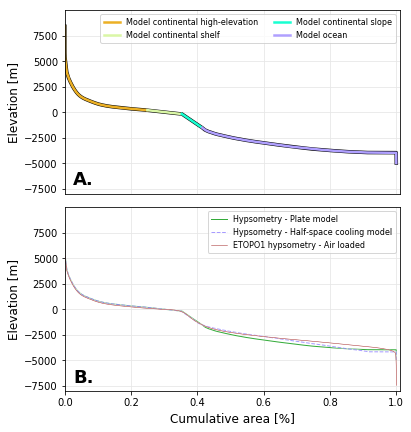

In [24]:
# plot modeled hypso components
Pk = pd.read_csv('/Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/HypsometryModeling/gld428_0-560Ma_ModeledHypsometry_AL_fOA_fS_Pk/gld428_HypsoModelFinal_0Ma_fOA_fS_Pk.csv',
                   names=['Area_per', 'ELEVATION'], usecols=['Area_per', 'ELEVATION'])

HSCk = pd.read_csv('/Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/HypsometryModeling/gld428_0-560Ma_ModeledHypsometry_AL_fOA_fS_HSCk/gld428_HypsoModelFinal_0Ma_fOA_fS_HSCk.csv',
                   names=['Area_per', 'ELEVATION'], usecols=['Area_per', 'ELEVATION'])

# KRCC = pd.read_csv('./gld428_0-560Ma_ModeledHypsometry_AL_fOA_fS_KRCC/gld428_HypsoModelFinal_0Ma_fOA_fS_KRCC.csv',
#                    names=['Area_per', 'ELEVATION'], usecols=['Area_per', 'ELEVATION'])


etopoHist.loc[etopoHist.ELEVATION <= 0.0, 'ELEVATION_AL'] = etopoHist.ELEVATION * 0.6918238993710691
etopoHist.loc[etopoHist.ELEVATION > 0.0, 'ELEVATION_AL'] = etopoHist.ELEVATION
    
# Plot baseCase
plt.clf()
plt.cla()
plt.close()

font = {'family': 'helvetica',
        'color':  'black',
        'weight': 'bold',
        'size': 18,
        }

fig = plt.figure(figsize=(6,7))
ax1 = plt.subplot(211)

ax1.plot(Pk['Area_per'], Pk['ELEVATION'], color='Black', linewidth=3.5, label="_nolegend_")
ax1.plot(contHypso['Area_per'], contHypso['ELEVATION'], color='#ECB025', linewidth=2.5, label="Model continental high-elevation")
ax1.plot(coast_hidef['Area_per'], coast_hidef['ELEVATION'], color='#DAF7A6', linewidth=2.5, label="Model continental shelf")
ax1.plot(slope_hidef['Area_per'], slope_hidef['ELEVATION'], color='#18FFD1', linewidth=2.5, label="Model continental slope")
ax1.plot(oceanicHypso['Area_per'], oceanicHypso['ELEVATION'], color='#B0A0FF', linewidth=2.5, label="Model ocean")
# ax1.plot(etopoHist['Area_per'], etopoHist['ELEVATION_AL'], color='#C70039', linestyle='--', linewidth=2.5, label="ETOPO1 - Air loaded")

# ax1.axhline(200, linestyle='-', linewidth=0.5, color='brown', zorder=2, label = 'Zshelf')
# ax1.axhline(0, linestyle='-', linewidth=0.5, color='grey', zorder=2, label = '0m')
# ax1.axhline(-250, linestyle='-', linewidth=0.5, color='blue', zorder=2, label = 'Zslope')
# ax1.axhline(dmax, linestyle='-', linewidth=0.5, color='purple', zorder=2, label = 'Zr')


ax1.set_ylabel('Elevation [m]', fontsize=12)
ax1.xaxis.set_label_position('top') 
ax1.tick_params(axis="x", bottom=False, top=False, labelbottom=False, labeltop=False)
plt.legend(facecolor="white", loc='best', prop={'size': 8}, ncol=2)
plt.grid(color="#E7E7E7")
plt.text(0.025, 0.025,'A.',
     horizontalalignment='left',
     verticalalignment='bottom',
     transform = ax1.transAxes, fontdict=font)
plt.xlim(0, 1.01)
plt.yticks(list(range(-7500, 10000, 2500)))
plt.ylim(-8000, 10000)

ax2 = plt.subplot(212)

ax2.plot(Pk['Area_per'], Pk['ELEVATION'], color='white', linewidth=1.5, label="_nolegend_")
ax2.plot(Pk['Area_per'], Pk['ELEVATION'], color='#34AB3A', linewidth=1, label="Hypsometry - Plate model")

ax2.plot(HSCk['Area_per'], HSCk['ELEVATION'], color='white', linewidth=1.5, label="_nolegend_", alpha=0.6)
ax2.plot(HSCk['Area_per'], HSCk['ELEVATION'], color='#6D59FF', linewidth=1, label="Hypsometry - Half-space cooling model", alpha=0.6, linestyle="--")

# ax2.plot(KRCC['Area_per'], KRCC['ELEVATION'], color='white', linewidth=1.5, label="_nolegend_", alpha=0.6)
# ax2.plot(KRCC['Area_per'], KRCC['ELEVATION'], color='#FF5959', linewidth=1, label="Hypsometry - Complex plate model", alpha=0.6, linestyle=":")

ax2.plot(etopoHist['Area_per'], etopoHist['ELEVATION_AL'], color='white', linewidth=.75, label="_nolegend_")
ax2.plot(etopoHist['Area_per'], etopoHist['ELEVATION_AL'], color='brown', linewidth=.5, label="ETOPO1 hypsometry - Air loaded")

ax2.set_ylabel('Elevation [m]', fontsize=12)
ax2.set_xlabel('Cumulative area [%]', fontsize=12)
ax2.xaxis.set_label_position('bottom') 
ax2.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
plt.legend(facecolor="white", loc='best', prop={'size': 8}, ncol=1)
plt.grid(color="#E7E7E7")
plt.text(0.025, 0.025,'B.',
     horizontalalignment='left',
     verticalalignment='bottom',
     transform = ax2.transAxes, fontdict=font)
plt.xlim(0, 1.01)
plt.yticks(list(range(-7500, 10000, 2500)))
plt.ylim(-8000, 10000)



plt.subplots_adjust(hspace = .075)
# fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.align_labels()

# # Save figure
plt.savefig('/Users/ajy321/PhD_work/SeaLevel/EPSL_r3_calcs_05072021/HypsometryModeling/Figure7_ModeledHypsometry_06072021.pdf', format='pdf', dpi=800 , bbox_inches = 'tight')
plt.show()